For this chapter we'll be participating in a real kaggle competition and evaluate each of the regularization techniques of the chapter 7                                                                                                               
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/overview                                                       
dataset from                                                                                                                  
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/discussion/182930

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import os
from PIL import Image
import PIL

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# import cv2
import glob

from tqdm import tqdm

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device
    
device

device(type='cuda')

In [3]:
train_path = 'D:\\lungs\\train-jpegs'
csv_path = 'E:\\Download\\new_downloads\\train.csv'

In [4]:
df_train = pd.read_csv(csv_path)

In [5]:
df_train.shape

(1790594, 17)

In [6]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [7]:
df_train.tail()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
1790589,4833c9b6a5d0,57e3e3c5f910,da0ecef50cf5,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790590,4833c9b6a5d0,57e3e3c5f910,d74b46c2f2c4,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790591,4833c9b6a5d0,57e3e3c5f910,ba71189191ad,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790592,4833c9b6a5d0,57e3e3c5f910,f4fdc88f2ace,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790593,4833c9b6a5d0,57e3e3c5f910,f890efd48940,1,0,0,0,0,0,1,1,1,0,0,0,0,0


In [8]:
image_level_features = ['pe_present_on_image']
# exam_level_features = ['negative_exam_for_pe', 
exam_level_features = ['indeterminate', 'chronic_pe', 'acute_and_chronic_pe', 'central_pe', 'leftsided_pe', 'rightsided_pe', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',]
informational_features = ['qa_motion', 'qa_contrast', 'true_filling_defect_not_pe', 'flow_artifact']

In [11]:
label_0_fraction = 2.7

In [12]:
df_train.loc[df_train['pe_present_on_image'] == 0, exam_level_features] = 0
df_train[df_train.pe_present_on_image == 1].shape[0], df_train[df_train.pe_present_on_image == 0].shape[0], df_train[df_train.pe_present_on_image == 1].shape[0]/df_train[df_train.pe_present_on_image == 0].shape[0] # high inbalance

train_df_0 = df_train[df_train.pe_present_on_image == 0].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*label_0_fraction), replace=False)
train_df_1 = df_train[df_train.pe_present_on_image == 1].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*0.8), replace=False)

In [13]:
train_df = train_df_0.append(train_df_1, ignore_index=False)

In [14]:
train_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
197841,bcc90630d363,2ab9cbf0a970,902437096a8a,0,0,0,0,0,0,0,0,0,0,0,0,0,0
618716,311beb3ccbd9,4a31b22ea1e5,d7016d73cd38,0,0,0,0,0,0,0,0,0,0,0,0,0,0
104167,68e00edca978,72da3987a603,26157ea7059a,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1244033,03ff66b1cc11,cf1759a628b2,d5e6cee57649,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1623959,4f64ef084d64,c8653b0dcb97,8d4f1fc6d777,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087320,49815063749c,f62bb073c02d,2c4f3f749dc4,1,0,0,0,0,1,0,0,0,0,1,0,1,0
77982,e6fc04eceaad,d3f18e516e1d,19a2047726cd,1,0,0,0,0,0,1,1,0,0,1,0,0,0
691266,ab336b035f00,9e398c74218b,37ae9cf8bb14,1,0,0,0,0,1,0,1,0,0,1,1,1,0
1049009,b74803f30fca,a904c562534c,2cd422b5ff9e,1,0,0,0,0,0,1,1,1,0,1,0,0,0


In [15]:
df_train = df_train.drop(train_df.index)

In [16]:
# df_train[df_train.pe_present_on_image==1]
val_df = df_train[df_train.pe_present_on_image==1].append(df_train[df_train.pe_present_on_image==0].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*2.5), replace=False))

In [17]:
val_df = val_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [18]:
del df_train

In [19]:
train_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,0ac1801fa355,fdaf80f04735,fb3a00821ef9,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,13f188f3bf15,2a775d62118a,47fbecf735ca,1,0,0,0,0,0,1,1,0,0,0,0,0,0
2,fbc3d7d901c9,61a54c834bba,c476be93572c,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,212472baf0b6,1d39cb4dabf2,7f705dfe1517,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0bdde09eba28,abeed2ef579a,1369e23f7745,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337885,17c786dc57b8,3263304113ba,4ab6c3a97c66,0,0,0,0,0,0,0,0,0,0,0,0,0,0
337886,d766f804c9fd,e3f79c0b51f0,7937c71b9ff0,1,0,0,0,0,1,0,1,0,0,1,1,0,0
337887,90bdd62a8b54,7ba21434c065,0629f57c8941,0,1,0,0,0,0,0,0,0,0,0,0,0,0
337888,8c87d014fa6f,2f6e5211ed42,26f5f2327baa,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
val_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,ad246a097fa6,f697bc2569eb,17fca86286d9,1,0,0,0,0,1,0,1,0,0,1,0,1,0
1,9233a407550f,a9b8f6aa8737,f8359c107e96,1,0,0,0,0,1,0,1,0,0,1,0,1,0
2,486fc8e335a3,ce2af12b5bc5,691aa9baea1d,1,0,0,0,0,0,1,1,1,0,1,0,0,0
3,b5fb8c062614,560ce6268c6e,f9a069eb9d89,1,0,0,0,0,0,1,1,0,0,1,0,0,0
4,de9e82cbd095,962f6720ad61,927a2607a117,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67573,f92b8b063d30,d6abd312734e,434fb3670d8a,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67574,84fa4ac4cfd4,afb7b590b8b1,1a921d2411f0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
67575,a10a3f7c27bb,7db14bcc90cb,1d0b5b12e9cb,1,0,0,0,0,0,1,0,0,0,1,0,0,0
67576,c7470e149485,34a5b0b544c8,b431b07c60e0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
def get_an_image(df, idx=0):
    row = df.iloc[idx]
    img = Image.open(glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])
    return img

In [22]:
img = get_an_image(train_df, 0)

In [23]:
np.array(img).shape

(256, 256, 3)

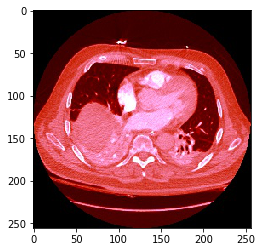

In [24]:
plt.imshow(img)

In [25]:
def plot_image(img):
    plt.figure(figsize=[12,6])
    plt.subplot(131)
    plt.imshow(img[:,:,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(img[:,:,1],cmap='gray')
    plt.subplot(133)
    plt.imshow(img[:,:,2],cmap='gray')

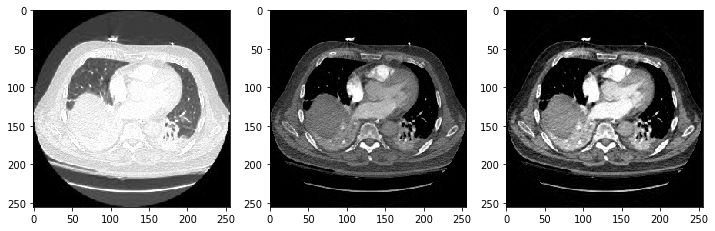

In [26]:
plot_image(np.array(img))

In [27]:
informational_features

['qa_motion', 'qa_contrast', 'true_filling_defect_not_pe', 'flow_artifact']

In [28]:
class LungsDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):

        row = self.csv_file.iloc[idx]
        img = Image.open(glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])

        img = self.transform(img).to(device)
        targets = torch.tensor(row[image_level_features+exam_level_features].values.astype(np.float16)).float().to(device)

        return img, targets

In [29]:
normalize = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
)

ds_trans = transforms.Compose([
                                transforms.Resize((224, 224)),
#                                 '''
#                                 7.4 - Dataset Augmentation
#                                 '''
                                transforms.RandomApply([ 
#                                     transforms.ColorJitter(hue=.05, saturation=.05,),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)],p=0.5),
                                transforms.ToTensor(),
                                normalize
])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [30]:
train_dataset = LungsDataset(train_df, transform=ds_trans)

val_dataset = LungsDataset(val_df, transform=ds_trans)

len(train_dataset), len(val_dataset)

(337890, 67578)

In [31]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [32]:
resnet34 = models.resnet34(pretrained=True)
fc_feat_size = resnet34.fc.in_features
resnet34.fc.in_features, resnet34.fc.out_features

(512, 1000)

In [33]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def __forward__(self, x):
        x = x.view(x.size(0), -1)
        return x
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [34]:
resnet34.avgpool = Identity()
resnet34.fc = Identity()

In [35]:
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
fc_feat_size

512

In [37]:
# 7.7 - Multi-Task Learning
def weights_init(m):
    classname = m.__class__.__name__
    for l in m.modules():
        if isinstance(l, nn.Conv2d):
            torch.nn.init.uniform_(l.weight)
        elif isinstance(l, nn.BatchNorm2d):
            torch.nn.init.uniform_(l.weight)
        elif isinstance(l, nn.Linear):
            torch.nn.init.xavier_normal_(l.weight)
        
class MultiTaskHead(nn.Module):
    def __init__(self):
        super(MultiTaskHead, self).__init__()
        self.m = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=(1,1), stride=(1,1), bias=False), 
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
                nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.AdaptiveAvgPool2d(output_size=(1,1)),
        )
        self.l = nn.Sequential(
                nn.Linear(2048, fc_feat_size, bias=True), 
            # 7.12 - Dropout
                nn.Dropout(),
                nn.ReLU(),
                nn.Linear(fc_feat_size, 128, bias=True), 
#                 nn.Dropout(),
#                 nn.Linear(256, 128, bias=True), 
#                 nn.Dropout(),
                nn.Linear(128, 1), 
#                 nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], 512, int(np.sqrt(x.shape[1]/512)), int(np.sqrt(x.shape[1]/512)))
        x = self.m(x)
        x = self.l(x.squeeze())
        return x

class WrapperModel(nn.Module):
    def __init__(self, pretrained_model):
        super(WrapperModel, self).__init__()
        self.stage = 'train'
        
        self.backbone = pretrained_model
        '''
        image-level feature
        '''
        self.linear_pe_present_on_image = MultiTaskHead()
        weights_init(self.linear_pe_present_on_image)
        '''
        exam-level features
        '''
        self.linear_negative_exam_for_pe = MultiTaskHead()
        weights_init(self.linear_negative_exam_for_pe)
        
        self.linear_indeterminate = MultiTaskHead()
        weights_init(self.linear_indeterminate)
        
        self.linear_chronic_pe = MultiTaskHead()
        weights_init(self.linear_chronic_pe)
        
        self.linear_acute_and_chronic_pe = MultiTaskHead()
        weights_init(self.linear_acute_and_chronic_pe)
        
        self.linear_central_pe = MultiTaskHead()
        weights_init(self.linear_central_pe)
        
        self.linear_leftsided_pe = MultiTaskHead()
        weights_init(self.linear_leftsided_pe)
        
        self.linear_rightsided_pe = MultiTaskHead()
        weights_init(self.linear_rightsided_pe)
        
        self.linear_rv_lv_ratio_gte_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_gte_1)
        
        self.linear_rv_lv_ratio_lt_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_lt_1)
        
#         '''
#         informational features
#         '''
#         self.linear_qa_motion = MultiTaskHead()
#         weights_init(self.linear_qa_motion)
        
#         self.linear_qa_contrast = MultiTaskHead()
#         weights_init(self.linear_qa_contrast)
                
#         self.linear_true_filling_defect_not_pe = MultiTaskHead()
#         weights_init(self.linear_true_filling_defect_not_pe)
        
#         self.linear_flow_artifact = MultiTaskHead()
#         weights_init(self.linear_flow_artifact)

    def forward(self, x):

        x = self.backbone(x)
        
        x_pe_present_on_image = self.linear_pe_present_on_image(x)
        
        x_negative_exam_for_pe = self.linear_negative_exam_for_pe(x)
        x_indeterminate = self.linear_indeterminate(x)
        x_chronic_pe = self.linear_chronic_pe(x)
        x_acute_and_chronic_pe = self.linear_acute_and_chronic_pe(x)
        x_central_pe = self.linear_central_pe(x)
        x_leftsided_pe = self.linear_leftsided_pe(x)
        x_rightsided_pe = self.linear_rightsided_pe(x)
        x_rv_lv_ratio_gte_1 = self.linear_rv_lv_ratio_gte_1(x)
        x_rv_lv_ratio_lt_1 = self.linear_rv_lv_ratio_lt_1(x)
        
#         x_qa_motion = self.linear_qa_motion(x)
#         x_qa_contrast = self.linear_qa_contrast(x)
#         x_true_filling_defect_not_pe = self.linear_true_filling_defect_not_pe(x)
#         x_flow_artifact = self.linear_flow_artifact(x)

        return torch.cat([ x_pe_present_on_image, x_indeterminate, x_chronic_pe, x_acute_and_chronic_pe, x_central_pe, x_leftsided_pe, x_rightsided_pe, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1], 1)
                      
model = WrapperModel(resnet34).to(device)

In [38]:
model

WrapperModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [39]:
for name, param in model.named_parameters():
#     if not (name.startswith('backbone.layer3') or name.startswith('backbone.layer4') or name.startswith('backbone.Mixed_') or name.startswith('linear')):
    if not (name.startswith('backbone.layer2') or name.startswith('backbone.layer3') or name.startswith('backbone.layer4') or name.startswith('linear')):
        param.requires_grad = False
    else:
        param.requires_grad = True

In [40]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

backbone.conv1.weight False
backbone.bn1.weight False
backbone.bn1.bias False
backbone.layer1.0.conv1.weight False
backbone.layer1.0.bn1.weight False
backbone.layer1.0.bn1.bias False
backbone.layer1.0.conv2.weight False
backbone.layer1.0.bn2.weight False
backbone.layer1.0.bn2.bias False
backbone.layer1.1.conv1.weight False
backbone.layer1.1.bn1.weight False
backbone.layer1.1.bn1.bias False
backbone.layer1.1.conv2.weight False
backbone.layer1.1.bn2.weight False
backbone.layer1.1.bn2.bias False
backbone.layer1.2.conv1.weight False
backbone.layer1.2.bn1.weight False
backbone.layer1.2.bn1.bias False
backbone.layer1.2.conv2.weight False
backbone.layer1.2.bn2.weight False
backbone.layer1.2.bn2.bias False
backbone.layer2.0.conv1.weight True
backbone.layer2.0.bn1.weight True
backbone.layer2.0.bn1.bias True
backbone.layer2.0.conv2.weight True
backbone.layer2.0.bn2.weight True
backbone.layer2.0.bn2.bias True
backbone.layer2.0.downsample.0.weight True
backbone.layer2.0.downsample.1.weight True
ba

In [41]:
criterion = nn.BCEWithLogitsLoss() # 7.5.1 may addlabel smoothing
optimizer = optim.Adamax(model.parameters(), lr=0.0008, weight_decay=5e-5) # 7.1 - L2-penalty

In [42]:
def compute_accuracy(y_pred, y_true, threshold=0.5):
    '''
    computes accuracy, precision and recall
    '''
    y_pred_ = torch.sigmoid(y_pred.clone())
    y_true_ = y_true.clone()
    try:
        res =  ((y_pred_ >= threshold)==y_true_).sum().item()/(y_pred_.shape[0]*y_true_.shape[1]), ((y_pred_ >= threshold)*y_true_).sum().item()/y_true_.sum().item(), ((y_pred_ >= threshold)*y_true_).sum().item()/y_pred_.sum().item()
        return res
    except:
        return 0,0,0

In [43]:
def evaluate_on(model, dataloader, stage):
    print('Evaluating on', stage)
    
    running_loss = []
    running_accuracy = []
    running_precision = []
    running_recall = []
    
    model.eval()
    with torch.no_grad():
        for x,y in tqdm(dataloader, total=len(dataloader)):
            total_loss = 0
            y_pred = model(x)
            for i in range(y.shape[1]):
                loss_i = criterion(y_pred[:,i], y[:,i])
                total_loss += loss_i
            running_loss.append(total_loss.item())
            accur, prec, rec = compute_accuracy(y_pred, y)
            running_accuracy.append(accur)
            running_precision.append(prec)
            running_recall.append(rec)
            
    return np.array(running_loss).mean(), np.array(running_accuracy).mean(), np.array(running_precision).mean(), np.array(running_recall).mean()

In [44]:
torch.autograd.set_detect_anomaly(True)

epochs = 100

running_losses = []
train_losses = []
train_accuracies = []
val_losses = [1e4]
val_precisions = []
val_recalls = []
val_accuracies = []

model.train()
for epoch in range(epochs):  
    print('Epoch Number:', epoch)
    running_loss = 0.0
    for j, (x,y) in enumerate(train_dataloader):

        optimizer.zero_grad()
        
        y_pred = model(x)
        
        total_loss = 0

        for i in range(y.shape[1]):
#             loss_i = criterion(y_pred[:,i], y[:,i])
#             loss_i.backward()
            total_loss = total_loss + criterion(y_pred[:,i], y[:,i])
            
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        if j % 100 == 0: 
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
        
            val_loss, val_accuracy, val_prec, val_rec = evaluate_on(model, val_dataloader, 'validation')
            print('val_loss, val_accuracy', val_loss, val_accuracy)
            print('val_prec, val_rec', val_prec, val_rec)
#             train_loss, train_accuracy = evaluate_on(model, train_dataloader, 'train')
#             print('train_loss, train_accuracy', train_loss, train_accuracy)
            if val_loss < min(val_losses):
                torch.save(model.state_dict(), ('E:/Download/new_downloads/checkpoints/resnet_'+str(val_loss)+'_'+str(val_accuracy)+'_'+'_'+str(val_prec)+'_'+str(val_rec)).replace('.','_'))
            
            running_losses.append(running_loss)
#             train_losses.append(train_loss)
            val_losses.append(val_loss)
            
#             train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_prec)
            val_recalls.append(val_rec)

            model.train()
            running_loss = 0.0
            
print('Finished Training')

Epoch Number: 0


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 0.063
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [09:39<00:00,  1.82it/s]


val_loss, val_accuracy 1230.1745769327338 0.0
val_prec, val_rec 0.0 0.0


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.604
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.96it/s]


val_loss, val_accuracy 2.7116172166936323 0.8642580392647742
val_prec, val_rec 0.0 0.0


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.282
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 2.5723224943785956 0.8642828700075468
val_prec, val_rec 0.017227603410569566 0.019040505563287926


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.205
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:20<00:00,  2.77it/s]


val_loss, val_accuracy 2.3977219348378256 0.8682420695823173
val_prec, val_rec 0.05307112253236028 0.057971883420436646


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.115
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.5395218657724783 0.863922654163764
val_prec, val_rec 0.0014589581886554814 0.0019972341967823383


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.203
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 2.662912018935789 0.8639456707883432
val_prec, val_rec 0.0026557153936489237 0.004994078366610587


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.192
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 2.4989945145718977 0.857079743646958
val_prec, val_rec 0.26240050130592896 0.23361709744355813


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.060
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 2.6765419435546254 0.8635658964827878
val_prec, val_rec 0.007142691894733939 0.01206364113075688


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.092
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 3.0232827482801494 0.8634838643257285
val_prec, val_rec 0.007133031139224516 0.017500151995946404


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.993
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.713681918314912 0.8661197780607802
val_prec, val_rec 0.029053600347990045 0.06077039736069046


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.035
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 2.549391549645048 0.8724034866444618
val_prec, val_rec 0.08958690703449954 0.1530552955792028


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.161
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.337835386282567 0.879811608360908
val_prec, val_rec 0.1993691929916052 0.23728202627819192


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.084
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.7546872362268693 0.8576040804960525
val_prec, val_rec 0.013903539408730577 0.018974094825940157


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.148
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 2.8057055782639617 0.8687329586272206
val_prec, val_rec 0.06735121488591768 0.13374526038772747


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.123
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.2984807843511756 0.8837638916100662
val_prec, val_rec 0.23471111661608424 0.27518363029294474


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.060
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.391838905711969 0.8825910075068211
val_prec, val_rec 0.19452622325454128 0.296331947814814


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 2.076
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 2.343653712082993 0.8766835583746952
val_prec, val_rec 0.5495920703795135 0.43792412916530543


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.959
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.96it/s]


val_loss, val_accuracy 2.194652552180218 0.8913393090386625
val_prec, val_rec 0.4994294145211619 0.4479074823031643


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.999
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.544950248504227 0.8817939860167769
val_prec, val_rec 0.15316269558936035 0.28780940388985954


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.909
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 2.1354507800530302 0.8955913186280913
val_prec, val_rec 0.39892157681341556 0.3994259011154125


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.853
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.1386005145808062 0.8964079552711018
val_prec, val_rec 0.43176265250537105 0.4679530895512204


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.942
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.2990699481557715 0.8861161793038139
val_prec, val_rec 0.18447181249892047 0.2878834796544886


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.910
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:00<00:00,  2.93it/s]


val_loss, val_accuracy 2.1679020501447446 0.8922218775397655
val_prec, val_rec 0.263042680597879 0.3479450848010213


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.856
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 2.2990044258309132 0.8876083482091025
val_prec, val_rec 0.20260709585880307 0.31338704760429276


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.827
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 2.154687813624288 0.8955558299409323
val_prec, val_rec 0.5464939493366247 0.49681462135201765


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.865
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.1250760109361373 0.8952641537501451
val_prec, val_rec 0.549637545066971 0.4939712025072271


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.865
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 2.1359835430753953 0.8993090704095553
val_prec, val_rec 0.36422051569039626 0.4579863803609502


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.859
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.0706635852429 0.8998453124092941
val_prec, val_rec 0.3465214198763863 0.4127883782445747


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.827
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.0555375629302226 0.9005708463042784
val_prec, val_rec 0.3641453749322464 0.4339620602475528


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.876
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.332042387376229 0.8893759796238244
val_prec, val_rec 0.21660759557876427 0.3650629494621475


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.821
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.0464008038468435 0.9031501822281724
val_prec, val_rec 0.4793991707052314 0.44027378825784386


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.821
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.1930257519989302 0.892697630035992
val_prec, val_rec 0.2506817739036835 0.36121549139530024


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.801
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 1.9940482257216265 0.9034451465081853
val_prec, val_rec 0.40641736963622804 0.42901194064118436


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.800
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 2.051110308165803 0.899988004143446
val_prec, val_rec 0.34108484049170523 0.39479119199597623


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.800
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.0329793333781487 0.9012177495138164
val_prec, val_rec 0.3489019281862642 0.44218824192715156


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.754
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 2.0507308388072434 0.9034211661333159
val_prec, val_rec 0.38747047258765255 0.4931917195325481


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.773
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 2.297887306265307 0.8949590417464879
val_prec, val_rec 0.2697031124578279 0.4593582003103102


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.817
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 1.941870888074239 0.906551540458464
val_prec, val_rec 0.5135166192391342 0.47691959871964534


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.739
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:00<00:00,  2.93it/s]


val_loss, val_accuracy 2.078280168387926 0.8957823679503367
val_prec, val_rec 0.27710367432355487 0.3498398090661528


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.754
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:00<00:00,  2.93it/s]


val_loss, val_accuracy 1.963918100026521 0.9061854287305526
val_prec, val_rec 0.4434856253252108 0.4818189527719249


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.773
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 1.9281152747571468 0.9072390912537732
val_prec, val_rec 0.4523870423038538 0.4801156848783341


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.729
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.9319135533137755 0.9062543085307093
val_prec, val_rec 0.4944636666638009 0.5054801614562958


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.660
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.1154531043474423 0.8954744213870022
val_prec, val_rec 0.2678591661038594 0.3995339368815537


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.737
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 1.8816418241370807 0.9098003426869267
val_prec, val_rec 0.470617756269857 0.4712849922985124


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.685
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.1919242213621284 0.9029433160629282
val_prec, val_rec 0.3647604955074331 0.5386880693590741


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.710
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 1.924148524123611 0.9082981394403808
val_prec, val_rec 0.5139398381931846 0.5294763396126522


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.684
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:01<00:00,  2.92it/s]


val_loss, val_accuracy 1.9859286987533171 0.9035213961635029
val_prec, val_rec 0.3501145191691988 0.4716343134943788


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.698
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.010585606436838 0.9043768095828979
val_prec, val_rec 0.35953164293051076 0.5062643669825481


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.587
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.9204712950934966 0.907313583482091
val_prec, val_rec 0.3901792969327563 0.49907330106297865


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.672
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.821035937885895 0.9123244613883084
val_prec, val_rec 0.5061855470659294 0.4977706806292982


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.645
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 1.8183398495117824 0.9120531940271972
val_prec, val_rec 0.506413511287019 0.536065313133337


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.613
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 1.812606513669545 0.9125892659533553
val_prec, val_rec 0.48471710320307904 0.5232184310851873


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[1,     9] loss: 1.601
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 1.8455508631851636 0.910121895136712
val_prec, val_rec 0.43383804993924097 0.5108728202305841
Epoch Number: 1


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 0.015
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 1.9055384919611793 0.9073194793662197
val_prec, val_rec 0.3760492472355388 0.5119885235292743


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.568
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 1.7913954214503367 0.9139258175323639
val_prec, val_rec 0.5262048216585375 0.5222616769056402


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.648
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.8660976708386883 0.9091830322804191
val_prec, val_rec 0.4406297548725873 0.4992036135067297


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.658
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.9140700575415834 0.9086536499150993
val_prec, val_rec 0.40180891479871855 0.5224459392376066


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.518
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 2.035649588388024 0.9036817188588471
val_prec, val_rec 0.3722469362968242 0.5211651601948533


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.614
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.95it/s]


val_loss, val_accuracy 1.8364848822468158 0.9128421653677581
val_prec, val_rec 0.4886039871360572 0.55972682776003


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.614
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 1.9350199597803028 0.9025342891015036
val_prec, val_rec 0.7043467801222904 0.5375095033445947


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.495
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.774936562234705 0.913735051666086
val_prec, val_rec 0.4534465501669457 0.5555021030795305


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.491
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.7699513091056636 0.9150558430932892
val_prec, val_rec 0.5086448996463895 0.5681777911516862


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.523
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.831377475945787 0.9148747714211076
val_prec, val_rec 0.4953183169035186 0.606554505639153


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.527
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 2.035082874029423 0.9008198340263266
val_prec, val_rec 0.30454892436887454 0.4996504932831825


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.576
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.808705640787428 0.9123532605146291
val_prec, val_rec 0.46254982598060207 0.5406848610328062


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.515
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.9373513750280396 0.9055787762684314
val_prec, val_rec 0.3385301857294127 0.5452562300214385


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.488
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:59<00:00,  2.94it/s]


val_loss, val_accuracy 1.703828643838113 0.9197937529025891
val_prec, val_rec 0.5374116088288524 0.6187380929557613


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.512
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.95it/s]


val_loss, val_accuracy 1.77782920578664 0.9183629238687159
val_prec, val_rec 0.4927681037152175 0.6568540586707123


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.467
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:57<00:00,  2.96it/s]


val_loss, val_accuracy 1.6473685692657123 0.9219284031043191
val_prec, val_rec 0.5446572009448984 0.6214398491481427


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.483
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:06<00:00,  2.88it/s]


val_loss, val_accuracy 1.6834229732666053 0.9184490377917103
val_prec, val_rec 0.6611937633283747 0.6013155048126384


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.437
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [10:28<00:00,  1.68it/s]


val_loss, val_accuracy 1.6552535441111436 0.921270558494427
val_prec, val_rec 0.5516021111594551 0.6053198962797244


  0%|                                                                                         | 0/1056 [00:00<?, ?it/s]

[2,     9] loss: 1.490
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [05:58<00:00,  2.94it/s]


val_loss, val_accuracy 1.7937019988894463 0.9170572122989956
val_prec, val_rec 0.46808420102636084 0.6445708074365639


KeyboardInterrupt: 

In [45]:
val_loss, val_losses

(1.7937019988894463,
 [10000.0,
  1230.1745769327338,
  2.7116172166936323,
  2.5723224943785956,
  2.3977219348378256,
  2.5395218657724783,
  2.662912018935789,
  2.4989945145718977,
  2.6765419435546254,
  3.0232827482801494,
  2.713681918314912,
  2.549391549645048,
  2.337835386282567,
  2.7546872362268693,
  2.8057055782639617,
  2.2984807843511756,
  2.391838905711969,
  2.343653712082993,
  2.194652552180218,
  2.544950248504227,
  2.1354507800530302,
  2.1386005145808062,
  2.2990699481557715,
  2.1679020501447446,
  2.2990044258309132,
  2.154687813624288,
  2.1250760109361373,
  2.1359835430753953,
  2.0706635852429,
  2.0555375629302226,
  2.332042387376229,
  2.0464008038468435,
  2.1930257519989302,
  1.9940482257216265,
  2.051110308165803,
  2.0329793333781487,
  2.0507308388072434,
  2.297887306265307,
  1.941870888074239,
  2.078280168387926,
  1.963918100026521,
  1.9281152747571468,
  1.9319135533137755,
  2.1154531043474423,
  1.8816418241370807,
  2.19192422136212

In [46]:
val_accuracies

[0.0,
 0.8642580392647742,
 0.8642828700075468,
 0.8682420695823173,
 0.863922654163764,
 0.8639456707883432,
 0.857079743646958,
 0.8635658964827878,
 0.8634838643257285,
 0.8661197780607802,
 0.8724034866444618,
 0.879811608360908,
 0.8576040804960525,
 0.8687329586272206,
 0.8837638916100662,
 0.8825910075068211,
 0.8766835583746952,
 0.8913393090386625,
 0.8817939860167769,
 0.8955913186280913,
 0.8964079552711018,
 0.8861161793038139,
 0.8922218775397655,
 0.8876083482091025,
 0.8955558299409323,
 0.8952641537501451,
 0.8993090704095553,
 0.8998453124092941,
 0.9005708463042784,
 0.8893759796238244,
 0.9031501822281724,
 0.892697630035992,
 0.9034451465081853,
 0.899988004143446,
 0.9012177495138164,
 0.9034211661333159,
 0.8949590417464879,
 0.906551540458464,
 0.8957823679503367,
 0.9061854287305526,
 0.9072390912537732,
 0.9062543085307093,
 0.8954744213870022,
 0.9098003426869267,
 0.9029433160629282,
 0.9082981394403808,
 0.9035213961635029,
 0.9043768095828979,
 0.9073135834

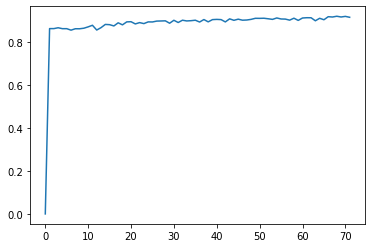

In [47]:
# validation accuracy 
plt.plot(range(len(val_accuracies)), val_accuracies)

In [48]:
val_losses

[10000.0,
 1230.1745769327338,
 2.7116172166936323,
 2.5723224943785956,
 2.3977219348378256,
 2.5395218657724783,
 2.662912018935789,
 2.4989945145718977,
 2.6765419435546254,
 3.0232827482801494,
 2.713681918314912,
 2.549391549645048,
 2.337835386282567,
 2.7546872362268693,
 2.8057055782639617,
 2.2984807843511756,
 2.391838905711969,
 2.343653712082993,
 2.194652552180218,
 2.544950248504227,
 2.1354507800530302,
 2.1386005145808062,
 2.2990699481557715,
 2.1679020501447446,
 2.2990044258309132,
 2.154687813624288,
 2.1250760109361373,
 2.1359835430753953,
 2.0706635852429,
 2.0555375629302226,
 2.332042387376229,
 2.0464008038468435,
 2.1930257519989302,
 1.9940482257216265,
 2.051110308165803,
 2.0329793333781487,
 2.0507308388072434,
 2.297887306265307,
 1.941870888074239,
 2.078280168387926,
 1.963918100026521,
 1.9281152747571468,
 1.9319135533137755,
 2.1154531043474423,
 1.8816418241370807,
 2.1919242213621284,
 1.924148524123611,
 1.9859286987533171,
 2.010585606436838,
 1

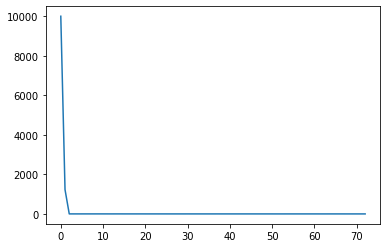

In [49]:
# validation loss 
plt.plot(range(len(val_losses)), val_losses)

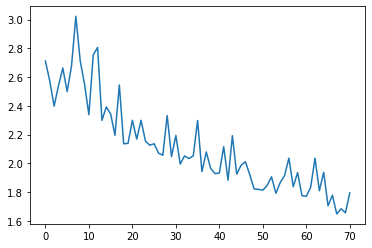

In [50]:
# validation loss 
plt.plot(range(len(val_losses[2:])), val_losses[2:])

In [69]:
model.load_state_dict(torch.load("D://resnet_1_6473685692657123_0_9219284031043191__0_5446572009448984_0_6214398491481427"))

<All keys matched successfully>

In [70]:
model.eval()

WrapperModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [93]:
for j, (x,y) in enumerate(val_dataloader):
    y_pred_eval = model(x)
    break
    
compute_accuracy(y_pred_eval, y, 0.3)

(0.8958333333333334, 0.5176470588235295, 0.7645437552004065)

In [94]:
y

tensor([[1., 0., 0., 0., 1., 1., 1., 1., 0.],
        [1., 0., 0., 0., 1., 1., 1., 1., 0.],
        [1., 0., 1., 0., 0., 1., 1., 0., 1.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

In [95]:
y_pred_eval

tensor([[ 4.1254e+00, -1.1285e+01, -6.3293e+00, -3.8870e+00,  2.3509e-01,
          2.6094e+00,  3.6206e+00,  8.2395e-01, -2.4447e-01],
        [-3.6828e-01, -1.1292e+01, -3.4787e+00, -3.3036e+00, -1.5687e+00,
         -7.4597e-01, -4.2474e-01, -8.3257e-01, -2.0525e+00],
        [-2.1969e+00, -1.1289e+01, -2.9058e+00, -5.2934e+00, -4.8921e+00,
         -2.6797e+00, -2.5849e+00, -3.5443e+00, -2.5287e+00],
        [ 4.1234e+00, -1.1285e+01, -3.5158e+00, -2.6136e+00,  5.9489e-01,
          2.5393e+00,  3.7310e+00,  9.1036e-01, -1.2371e-01],
        [-1.3657e+00, -1.1295e+01, -5.8870e+00, -4.9931e+00, -2.8638e+00,
         -1.7729e+00, -1.6867e+00, -2.6974e+00, -2.1667e+00],
        [-5.8738e+00, -1.1298e+01, -7.0047e+00, -9.0923e+00, -9.3606e+00,
         -5.5824e+00, -6.5063e+00, -6.4760e+00, -5.9236e+00],
        [-7.4951e+00, -1.1299e+01, -9.5741e+00, -9.9232e+00, -9.2277e+00,
         -7.3045e+00, -8.0112e+00, -8.1696e+00, -7.3187e+00],
        [-8.5974e+00, -1.1296e+01, -1.0382e+01, 

In [90]:
y_pred_eval = torch.sigmoid(y_pred_eval)

In [91]:
(y_pred_eval > 0.5).sum()

tensor(47, device='cuda:0')

In [84]:
(y_pred_eval > 0.5).type(torch.FloatTensor)

tensor([[1., 0., 0., 0., 1., 1., 1., 1., 0.],
        [1., 0., 0., 0., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

In [86]:
torch.save(model, 'C:\\Users\\David\\Desktop\\model.pth')